In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import find_peaks
import time

In [2]:
start = time.perf_counter()
# Parametry siatki
N = 2**12            # liczba punktów siatki - 1 w każdym kierunku
L = 25           # długość boku obszaru
x = np.linspace(-L/2, L/2, N)
dx = x[1] - x[0]         # krok przestrzenny

# Parametry fizyczne
ħ = 1.0
m = 1
dt = 0.003         # krok czasowy
Nt = 2**17
T_max = Nt * dt       # maksymalny czas
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")
T_max

Czas działania: 0.001284 sekundy


393.216

In [3]:
start = time.perf_counter()
# Potencjał: V(x, y)
# Warunki na przedział
x_min = -1
x_max = 1

# Inicjalizacja potencjału jako tablica zer
V = np.zeros_like(x)

# Obliczam V tylko tam, gdzie x mieści się w zadanym przedziale
mask = (x > x_min) & (x < x_max)
V[mask] = -0
V[~mask] = 5

# Początkowa funkcja falowa — funkcja Gaussa
a = 0.2
sigma = 0.2
ψ = np.exp(-(x - a)**2 / (2 * sigma**2))
ψ /= np.linalg.norm(ψ)  # normalizacja

ψ0 = ψ.copy()  # zapisuję funkcję początkową do korelacji
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.020160 sekundy


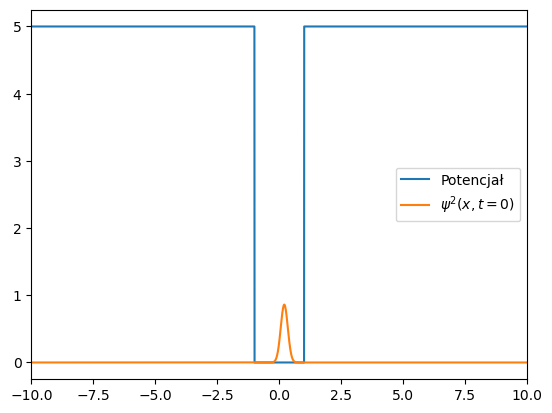

In [4]:
plt.plot(x, V, label = "Potencjał")
plt.plot(x, 50*np.abs(ψ)**2 - 0, label = "$ψ^2(x, t=0)$")
plt.xlim(-10, 10)
#plt.ylim(-155, -65)
plt.legend()

In [5]:
start = time.perf_counter()
# absorber (CAP) parametry
w = 0.30 * L      # szerokość absorbera po każdej stronie
x0 = L/2 - w       # punkt startu tłumienia (dla prawego brzegu, lewy analogicznie)
η0 = 1.0        # maksymalny współczynnik tłumienia
alpha = 2          # potęga (2..4)

# konstrukcja η(x)
η = np.zeros_like(x)
right_mask = x > (L/2 - w)
η[right_mask] = η0 * ((x[right_mask] - (L/2 - w)) / w)**alpha
left_mask = x < -(L/2 - w)
η[left_mask] = η0 * (((-L/2 + w) - x[left_mask]) / w)**alpha

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.000809 sekundy


In [6]:
'''
# Tłumienie PML (SES == Smooth Exterior Scaling)

w = 0.32 * L
sigma0 = 100.0
n = 2
sigma = np.zeros_like(x)
mask_r = x > (L/2 - w)
sigma[mask_r] = sigma0 * ((x[mask_r] - (L/2 - w))/w)**n
mask_l = x < -(L/2 - w)
sigma[mask_l] = sigma0 * ((-L/2 - w - x[mask_l])/w)**n

omega = 0.5
s = 1.0 + 1j * sigma / omega
'''

'\n# Tłumienie PML (SES == Smooth Exterior Scaling)\n\nw = 0.32 * L\nsigma0 = 100.0\nn = 2\nsigma = np.zeros_like(x)\nmask_r = x > (L/2 - w)\nsigma[mask_r] = sigma0 * ((x[mask_r] - (L/2 - w))/w)**n\nmask_l = x < -(L/2 - w)\nsigma[mask_l] = sigma0 * ((-L/2 - w - x[mask_l])/w)**n\n\nomega = 0.5\ns = 1.0 + 1j * sigma / omega\n'

In [7]:
start = time.perf_counter()
# FFT: przygotowanie współrzędnych pędu
kx = 2 * np.pi * fftfreq(N, dx)
K2 = kx**2

# Fazy propagacji
T_phase = np.exp(-1j * (ħ * K2 / (4 * m)) * dt)
V_phase = np.exp(-1j * V * dt / ħ)
η_phase = np.exp(- η * dt / ħ)

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.001296 sekundy


In [8]:
start = time.perf_counter()
psi_t = []  # Lista funkcji falowych w kolejnych chwilach czasu

# Rejestracja g1(t)
g1_t = []

#k = 0
# Pętla czasowa
for _ in range(Nt):
    # pół krok w pędzie
    ψ_temp = fft(ψ)
    ψ_temp *= T_phase
    ψ = ifft(ψ_temp)
#    ψ /= s  # Tłumienie SES

    # pełen krok w przestrzeni + CAP (complex absorbing potential)
    # jako warunek brzegowy absorbujący, żeby nie było interferencji
    # od ścianek siatki przestrzeni
    ψ *= V_phase
    ψ *= η_phase

    # drugi pół krok w pędzie
    ψ_temp = fft(ψ)
    ψ_temp *= T_phase
    ψ = ifft(ψ_temp)
    
    # Dodaję ψ do zbioru psi w czasie
    psi_t.append(ψ.copy())
    
    # obliczam g1(t)
    g1 = np.vdot(ψ0, ψ)
    g1_t.append(g1)

ψ_temp = []

# Robienie z psi_t wektora
psi_t = np.array(psi_t)

# Czas i amplituda korelacji
t_values = np.arange(Nt) * dt
g1_t = np.array(g1_t)
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 82.554075 sekundy


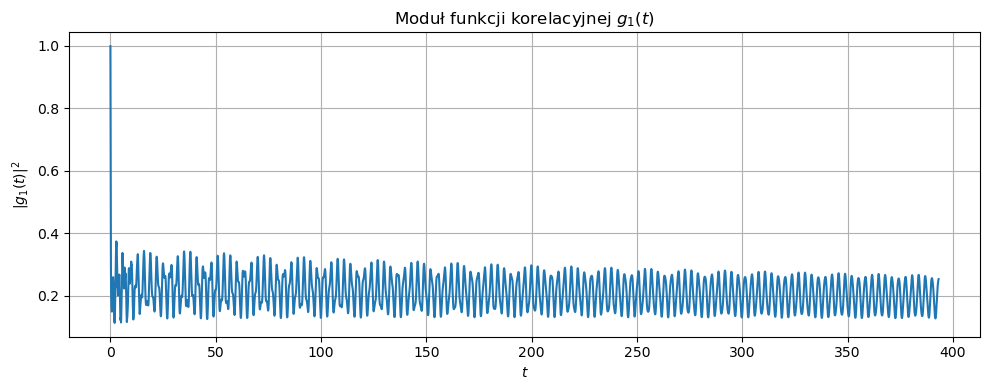

In [9]:
# Wykres
plt.figure(figsize=(10, 4))
plt.plot(t_values, np.abs(g1_t)**2)
plt.xlabel("$t$")
plt.ylabel(r"$|g_1(t)|^2$")
plt.title("Moduł funkcji korelacyjnej $g_1(t)$")
plt.grid(True)
plt.tight_layout()
#plt.xlim(3000,4000)
#plt.ylim(0,0.004)
plt.savefig("Studnia kwadratowa skończona g(t).pdf", bbox_inches='tight')
plt.show()

In [52]:
start = time.perf_counter()
# Stosuję funkcję okna do g1(t)
window = (1 - np.cos(2 * np.pi * t_values / T_max)) / T_max
#window = np.ones(len(t_values))
g1_windowed = g1_t * window

# Transformata Fouriera z oknem
g1_E = fft(g1_windowed)
freqs = fftfreq(Nt, dt)  # jednostki częstotliwości
E = 2 * np.pi * freqs * ħ  # przekształcenie na energię

# Przesuwam energie i funkcje korelacji
E = np.fft.fftshift(E)
g1_E = np.fft.fftshift(g1_E)
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.020215 sekundy


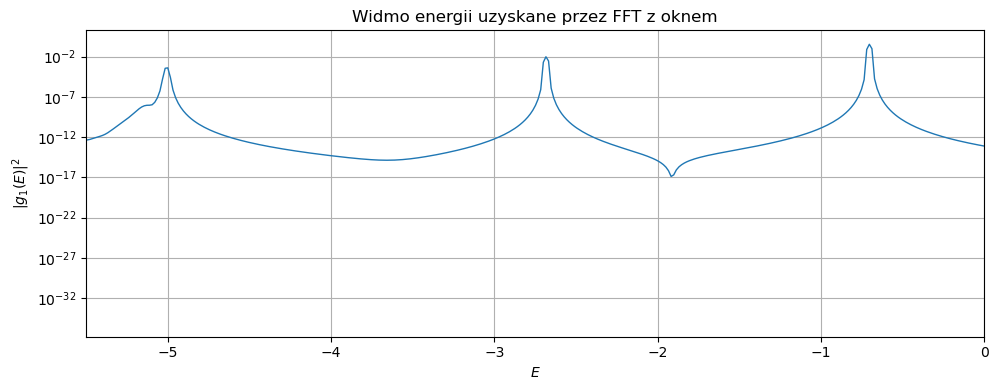

In [53]:
# Wykres widma
plt.figure(figsize=(10, 4))
plt.plot(E, np.abs(g1_E)**2 * 2 / len(g1_E), lw=1)
plt.xlim(-5.5, 0)
plt.xlabel("$E$")
plt.ylabel(r"$|g_1(E)|^2$")
plt.title("Widmo energii uzyskane przez FFT z oknem")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.savefig("Studnia kwadratowa skończona g(E).pdf", bbox_inches='tight')
plt.show()

In [54]:
start = time.perf_counter()
# Przepisuję g1_E do zręczniejszej postaci i ustawiam próg dla maksimów
g1_E_temp = (np.abs(g1_E)**2 * 2 / len(g1_E))
threshold = np.max(g1_E_temp) * 0


'''
# Wcześniejszy kod na poszukiwanie pików

# Szukam lokalnych maksimów: sprawdzam czy sąsiednie punkty są < od tego, który sprawdzamy + dodatkowo czy sprawdzany punkt nie jest > od progu (threshold)
peaks = (g1_E_temp[1:-1] > g1_E_temp[:-2]) & (g1_E_temp[1:-1] > g1_E_temp[2:]) & (g1_E_temp[1:-1] > threshold)
peak_indices = np.where(peaks)[0] + 1
peak_energies = E[peak_indices]
peak_amplitudes = g1_E_temp[peak_indices]
'''

# Szukam lokalnych maksimów
peak_indices, _ = find_peaks(np.abs(g1_E), height=threshold, prominence=0.01)

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 1.058904 sekundy


In [55]:
E[peak_indices]

array([-5.00141653, -2.68446638, -0.70307453])

In [ ]:
start = time.perf_counter()

def Gamma1(delta):
    # Funkcja Gamma
    return np.where(np.isclose(delta, 0), 1.0, (np.exp(2j * np.pi * delta) - 1) / (2j * np.pi * delta))

def Phi1(delta):
    # Funkcja Phi
    return Gamma1(delta) - 0.5 * (Gamma1(delta + 1) + Gamma1(delta - 1))

def choosing_delta_prime_from_R(R, T):
    # Funkcja, która wybiera deltę (== przesrunięcie wartości własnej E_n
    # z przyczyny tego, że mamy siatkę tylko z N_t elementów).
    # Korzystam z tej funkcji, bo w artkule Feita, Flecka i Steigera
    # dla wyboru δ' porównujemy R z 1, ale w obliczeniach mamy
    # R zespolone => nie możemy robić operacje < lub > z R.
    # Tu wybór się bazuje na 1) czy |δ'| < 1, 2) chcęmy δ' o mniejszej
    # części urojonej, bo energie są rzeczywistymi, 3) R, które mamy z
    # funkcji korelacji g_1(E), musi być bliskie do Phi(δ') dla
    # odpowiedniej δ'.
    
    # obliczam r = (1+R)/(1-R)
    r = (1 + R) / (1 - R)

    # rozwiązuję równanie kwadratowe δ'^2 - 3 r δ' + 2 = 0
    # δ'_{1,2} = (3r ± sqrt(9 r^2 - 8)) / 2
    discriminant = np.sqrt(9 * r**2 - 8)
    cand1 = (-3 * r + discriminant) / 2
    cand2 = (-3 * r - discriminant) / 2

    candidates = [cand1, cand2]

    # kryteria wyboru:
    best = None
    best_score = None
    for cand in candidates:
        # kryterium 1: czy realna część δ' leży w (-1, 1),
        # bo zakładamy, że jesteśmy blisko E_n
        in_range = np.abs(cand.real) < 1.0

        # kryterium 2: jak duża część urojona δ' (mniejsza => lepiej)
        imag_mag = np.abs(cand.imag)

        # kryterium 3: residual względem rzeczywistego R
        R_model = Phi1(cand + 1) / Phi1(cand - 1)
        residual = np.abs(R_model - R)

        # scoring: najpierw in_range, potem małe imag, potem mały residual
        # im mniejszy score, tym lepiej. Dlatego układamy odpowiednią ważność
        # kryteriów: 1), 3), 2)
        score = (0 if in_range else 1) + 1e-6 * imag_mag + 1e-9 * residual
        
        if (best is None) or (score < best_score):
            best = cand
            best_score = score

    # zwracam najlepsze δ'
    return best

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

In [56]:
start = time.perf_counter()

def compute_En_Wn(E, g1_E, m, T):
    # Funkcja dopasowania z pomocą lineshape fitting
    
    E_m = E[m]

    # zabezpieczenie brzegowe
    if m <= 0 or m >= len(E) - 1:
        return None

    g1_plus = g1_E[m + 1]
    g1_minus = g1_E[m - 1]
    g1_middle = g1_E[m]

    R = g1_plus / g1_minus

    delta_p = choosing_delta_prime_from_R(R, T)
    
#    r = (1 + R) / (1 - R)
#    discriminant = 9 * r**2 - 8
#    if np.real(discriminant) < 0:
#        return None  # nie ma pierwiastka rzeczywistego, pomijam

#    sqrt_term = np.sqrt(discriminant)

    
    
#    if np.abs(R) < 1:
#        delta_p = (-3 * r + sqrt_term) / 2
#    else:
#        delta_p = (-3 * r - sqrt_term) / 2

    E_n = E_m - (2 * np.pi * delta_p) / T
    phi = Phi1(delta_p)
    W_n = g1_middle / phi

    return E_n, W_n, delta_p, R

# Lista wyników
results = []

for m in peak_indices:
    res = compute_En_Wn(E, g1_E, m, T_max)
    if res is not None:
        E_n, W_n, delta_p, R = res
        results.append({
            'E_n': E_n.real,
            'W_n_abs': np.abs(W_n),
            'W_n_phase': np.angle(W_n),
            'delta_p': delta_p,
            'R': R
        })

# Sortowanie według energii

#results = [r for r in results if r['E_n'] >= -5]
for r in results: r['E_n'] *= -1
    
results.sort(key=lambda x: x['E_n'])

# Wyświetlenie wyników
print(f"{'E_n [a.u.]':>12} | {'|W_n|':>12} | {'arg(W_n) [rad]':>14} | {'δ′':>8}")
print(" " + "-" * 66)
for r in results:
    print(f"{(r['E_n']):12.6f} | {r['W_n_abs']:12.6e} | {r['W_n_phase']:14.6f} | {r['delta_p'].real:8.3f}")

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

  E_n [a.u.] |        |W_n| | arg(W_n) [rad] |       δ′
 ------------------------------------------------------------------
    0.703680 | 1.574139e+02 |      -0.001804 |    0.038
    2.685427 | 2.598110e+01 |      -0.008713 |    0.060
    4.994220 | 1.536129e+01 |      -0.148633 |   -0.450
Czas działania: 0.004554 sekundy


In [158]:
'''
# Zapisywanie funkcji do plików

np.save("funkcje psi(t) dla studni kwadratowej skończonej 1D.npy", psi_t)
np.save("Energie (po prostu energie) dla studni kwadratowej skończonej 1D.npy", E)
'''

'\n# Zapisywanie funkcji do plików\n\nnp.save("funkcje psi(t) dla studni kwadratowej skończonej 1D.npy", psi_t)\nnp.save("Energie (po prostu energie) dla studni kwadratowej skończonej 1D.npy", E)\n'

In [57]:
start = time.perf_counter()
# Stosujemy okno czasowe Hann jak wcześniej
psi_t_windowed = psi_t * window[:, np.newaxis]

# FFT po czasie, dla każdego x
psi_E = fft(psi_t_windowed, axis=0)  # shape: (Nt, Nx)

psi_E = np.fft.fftshift(psi_E, axes=0)  # Przesunięcie zerowej częstotliwości na środek

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 106.578415 sekundy


In [58]:
start = time.perf_counter()
eigen_psi = []

for r in results:
    # Znajduję najbliższy indeks na osi energii
    idx = np.argmin(np.abs(E + r['E_n']))
    psi_n = psi_E[idx, :]  # Funkcja falowa dla En (do normowania)
    eigen_psi.append(psi_n)

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.015119 sekundy


In [59]:
start = time.perf_counter()
eigen_psi_norm = [ψn / np.linalg.norm(ψn) for ψn in eigen_psi]
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.012592 sekundy


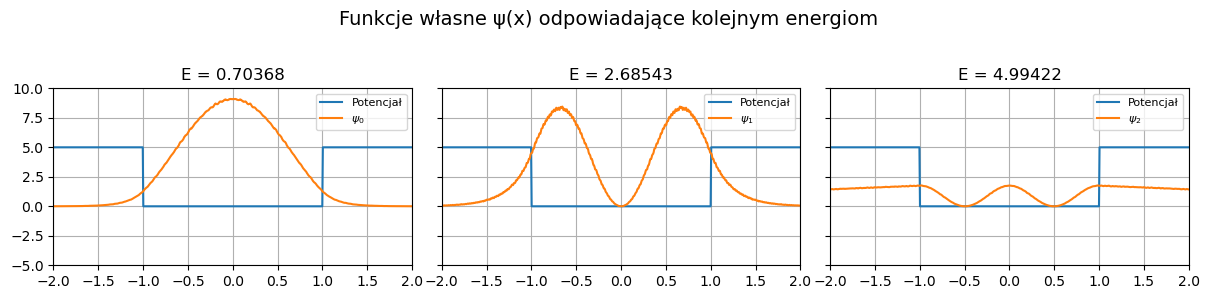

In [60]:
num_states = len(eigen_psi_norm)
cols = 3
rows = (num_states + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True, sharey=True)
axes = axes.flatten()

for i, ψn in enumerate(eigen_psi_norm):
    ax = axes[i]
    ax.plot(x, V, label = "Potencjał")
    ax.plot(x, 2000*np.abs(ψn)**2, label=r"$\psi_{%d}$" % i)
    ax.set_title(f"E = {(results[i]['E_n']):.5f}")
    ax.grid(True)
    ax.legend(fontsize=8)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-5, 10)

# Jeśli są puste komórki, wyłącz je
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Funkcje własne ψ(x) odpowiadające kolejnym energiom", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [61]:
np.save("funkcje psi(E) dla studni kwadratowej skończonej 1D SM.npy", eigen_psi_norm)

In [ ]:
def run_sim(eta0, n, w_frac, Nt_run):
    # To jest kod na sprawdzenie parametrów CAPu
    # zakładam że x, dx, dt, ħ, m, V, ψ0, etc. są już zdefiniowane globalnie
    w_local = w_frac * L
    eta = np.zeros_like(x)
    right_mask = x > (L/2 - w_local)
    eta[right_mask] = eta0 * ((x[right_mask] - (L/2 - w_local)) / w_local)**n
    left_mask = x < -(L/2 - w_local)
    eta[left_mask] = eta0 * (((-L/2 + w_local) - x[left_mask]) / w_local)**n

    η_phase = np.exp(- eta * dt / ħ)
    ψ = ψ0.copy()
    # przygotowuję T_phase i V_phase raz globalnie (jak masz)
    for _ in range(Nt_run):
        ψ_temp = fft(ψ)
        ψ_temp *= T_phase
        ψ = ifft(ψ_temp)
        ψ *= V_phase
        ψ *= η_phase
        ψ_temp = fft(ψ)
        ψ_temp *= T_phase
        ψ = ifft(ψ_temp)

    total_norm = np.sum(np.abs(ψ)**2) * dx
    center_mask = np.abs(x) < (L/4)
    P_center = np.sum(np.abs(ψ[center_mask])**2) * dx
    return total_norm, P_center

eta0_list = [1.0, 5.0, 20.0, 50.0, 100.0]
n_list = [2, 3, 4]
results = {}
for eta0 in eta0_list:
    for n in n_list:
        Nfin, Pcent = run_sim(eta0, n, w_frac=0.35, Nt_run=2**16)
        results[(eta0,n)] = (Nfin, Pcent)
        print("eta0=",eta0," n=",n," Nfin=",Nfin," Pcent=",Pcent)


In [ ]:
'''
start = time.perf_counter()
eigen_psi_norm = []

for r in results:
    phase = np.exp(1j * r['E_n'] * t_values)
    integrand = psi_t * (window[:, None] * phase[:, None])
    eigen_psi = np.trapz(integrand, t_values, axis=0)
    eigen_psi_norm.append(eigen_psi / np.linalg.norm(eigen_psi))

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")
'''

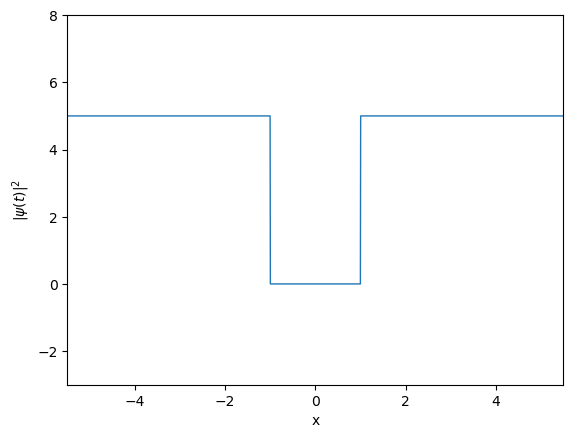

In [15]:
fig, ax = plt.subplots()

line_V, = ax.plot(x, V, lw=1,  label="V(x)")
line, = ax.plot([], [], lw=2)

ax.set_xlim(-5.5, 5.5)
#ax.set_xlim(L/4, L/2)
ax.set_ylim(-3, 8)
#ax.set_ylim(-0.3, 0.8)

ax.set_xlabel("x")
ax.set_ylabel("$|ψ(t)|^2$")
plt.show()

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = 500*np.abs(psi_t[frame])**2 - 0
    line.set_data(x, y)
    ax.set_title(f"t = {t_values[frame]:.2f}")
    return line,

ani = animation.FuncAnimation(fig, update, frames = range(0, Nt // 2**3, 15), init_func=init, blit=True)

In [16]:
# Robię filmik ewolucji funkcji w czasie

import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
import matplotlib as mpl

mpl.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\bin\ffmpeg.exe'

writer = FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=2800)
ani.save("kwadratowa studnia potencjału.mp4", writer=writer)